#Brain tumour classifier

##Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install the necessary libraries
!pip install pandas
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install pillow
!pip install keras

import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import class_weight
import itertools
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
from keras.layers import Input

Mounted at /content/drive


##Uploading Data

###Setting Kaggle

In [2]:
# Copy kaggle.json from Google Drive to ~/.kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Data Science/Master of Data Science and Innovation/MDSI-3S - Advanced Data Analytics Algorithms, Machine Learning/AT2/kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

###Downloading data

In [3]:
#Download
!kaggle datasets download -d thomasdubail/brain-tumors-256x256

#Unzip
!unzip brain-tumors-256x256.zip

#Check files
!ls


Dataset URL: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256
License(s): CC0-1.0
100% 59.4M/59.4M [00:00<00:00, 133MB/s]
100% 59.4M/59.4M [00:00<00:00, 134MB/s]
Archive:  brain-tumors-256x256.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Dat

### Creating Dataframe

In [4]:
# Define the base directory where images are stored
base_dir = 'Data/'

# Initialize lists to hold file paths and labels
image_paths = []
labels = []

for category in ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']:
    category_dir = os.path.join(base_dir, category)

    # Loop through each file in the directory
    for file_name in os.listdir(category_dir):
        # Full path to the image file
        file_path = os.path.join(category_dir, file_name)

        # Append the image path and label to the lists
        image_paths.append(file_path)
        labels.append(category)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(df.head())

                    image_path         label
0  Data/glioma_tumor/G_229.jpg  glioma_tumor
1   Data/glioma_tumor/G_42.jpg  glioma_tumor
2  Data/glioma_tumor/G_796.jpg  glioma_tumor
3  Data/glioma_tumor/G_346.jpg  glioma_tumor
4  Data/glioma_tumor/G_144.jpg  glioma_tumor


In [5]:
df['label'].value_counts()

,count
label,
meningioma_tumor,913
glioma_tumor,901
pituitary_tumor,844
normal,438


##Preprocessing

###Image preview

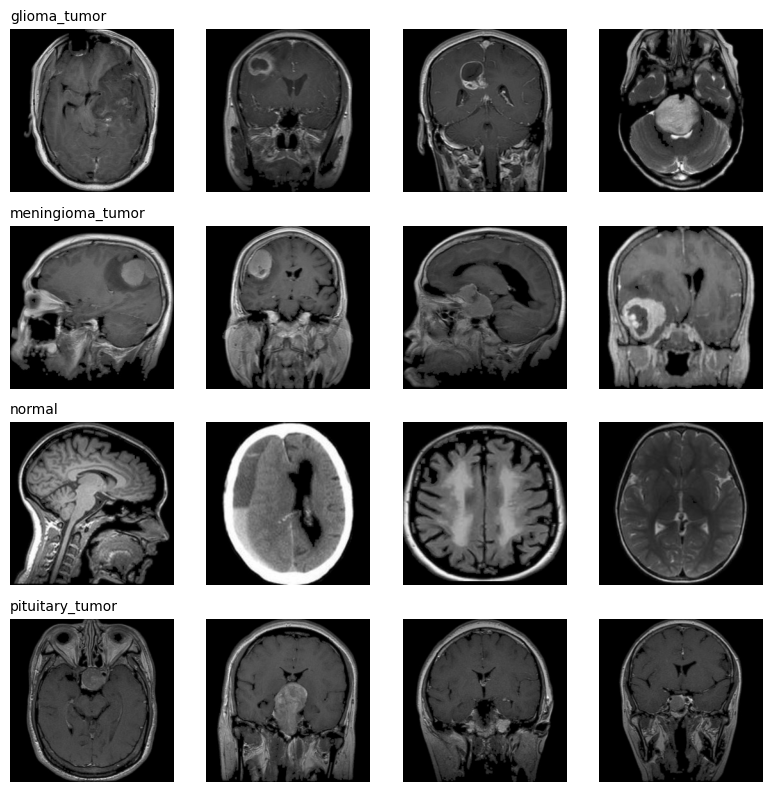

In [6]:
n_examples = 4

# Get unique classes from the 'label' column
classes = df['label'].unique()

# Create a figure with subplots with a smaller size
fig, axes = plt.subplots(len(classes), n_examples, figsize=(n_examples * 2, len(classes) * 2))

# Loop over each class
for i, class_label in enumerate(classes):
    # Select 'n_examples' images from each class
    class_images = df[df['label'] == class_label].sample(n=n_examples, random_state=42)

    # Loop over the images of this class
    for j, image_path in enumerate(class_images['image_path']):
        # Load the image
        img = Image.open(image_path)

        # Plot the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Remove axis

        # Add class label as title to the first column
        if j == 0:
            axes[i, j].set_title(class_label, fontsize=10, loc='left')

# Adjust layout to prevent overlapping
plt.tight_layout(pad=1.0)
plt.show()

###Image preprocessing

In [7]:
# Define the image size and batch size
image_size = (224, 224)

# Load and preprocess the images
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Preprocess all images
X = np.array([load_and_preprocess_image(image_path, image_size) for image_path in df['image_path']])
y = df['label'].values

###Label enconding

In [8]:
# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
y_encoded = np.array([label_mapping[label] for label in y])
y_one_hot = to_categorical(y_encoded)
# Class names for reference
class_names = list(label_mapping.keys())

In [9]:
# Print the class names and their corresponding encoded labels
for class_name, encoded_label in label_mapping.items():
    print(f"Class: {class_name}, Encoded Label: {encoded_label}")

Class: glioma_tumor, Encoded Label: 0
Class: meningioma_tumor, Encoded Label: 1
Class: normal, Encoded Label: 2
Class: pituitary_tumor, Encoded Label: 3


###Split

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, stratify=y_one_hot, random_state=42)

###Handling imbalanced data

As seen previosly, the class "normal" has ~400 pictures whereas the other classes have ~800, ~900. I will address this with the function compute_class_weight, which gives the model weights that are inversely proportional to the frequency of each class in the training dataset. This helps by assigning higher weights to the minority class and lower weights to the majority classes, during training.

In [11]:
# Compute class weights to address the imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))

###Data Augmentation

In [12]:
datagen = ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.005,
    height_shift_range=0.005,
    shear_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    fill_mode='nearest'
)

##Modelling

###Model 1

####Training Model 1

In [13]:
# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weights_dict,
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.3827 - loss: 7.8865 - val_accuracy: 0.1419 - val_loss: 20.4558
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 384s 5s/step - accuracy: 0.4102 - loss: 1.7684 - val_accuracy: 0.2984 - val_loss: 9.6068
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 465s 5s/step - accuracy: 0.4266 - loss: 1.3185 - val_accuracy: 0.3242 - val_loss: 10.6484
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 412s 5s/step - accuracy: 0.4795 - loss: 1.1824 - val_accuracy: 0.4774 - val_loss: 4.1638
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.5176 - loss: 1.0913 - val_accuracy: 0.4339 - val_loss: 4.7871
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 405s 5s/step - accuracy: 0.5528 - loss: 0.9919 - val_accuracy: 0.4355 - val_loss: 2.8774
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.5437 - loss: 1.0200 - val_accuracy: 0.4839 - val_loss: 2.4164
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - accuracy: 0.5865 - loss: 0.9187 - val_accuracy: 0.7323 - val_loss: 

####Evaluating model 1

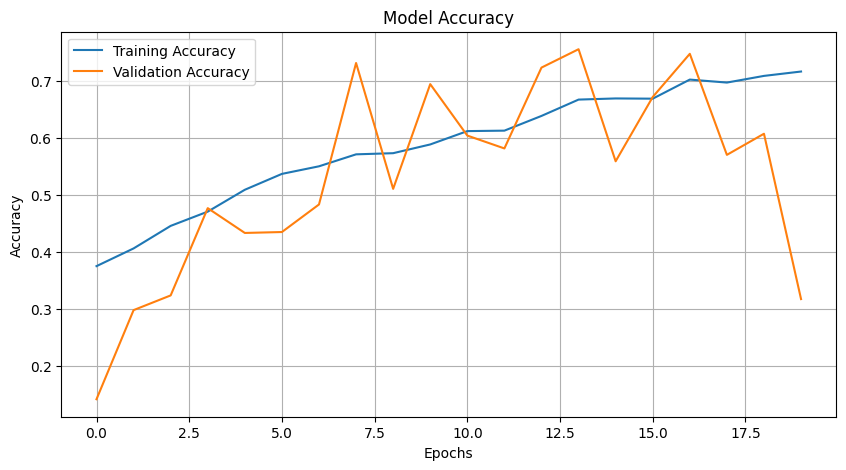

In [14]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

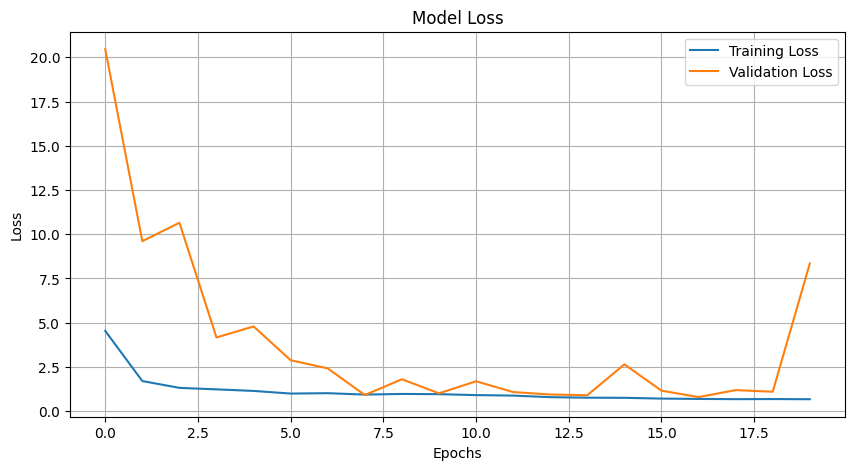

In [15]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


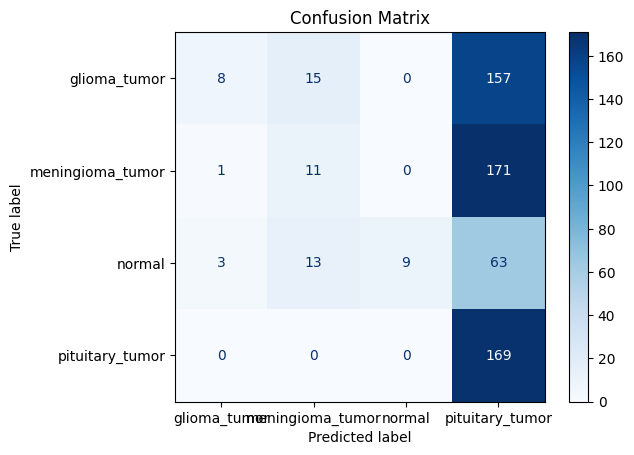

In [16]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred_classes)
print(f"Overall Accuracy: {accuracy}\n")

report = classification_report(np.argmax(y_val, axis=1), y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Overall Accuracy: 0.317741935483871

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.67      0.04      0.08       180
meningioma_tumor       0.28      0.06      0.10       183
          normal       1.00      0.10      0.19        88
 pituitary_tumor       0.30      1.00      0.46       169

        accuracy                           0.32       620
       macro avg       0.56      0.30      0.21       620
    weighted avg       0.50      0.32      0.21       620



###Model 2

####Training Model 2

In [18]:
# Define the CNN Model with more neurons, L2 regularization and reduced learning rate
model2 = Sequential([

    Input(shape=(image_size[0], image_size[1], 3)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.02)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.02)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.02)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#For reducing learning rate as training progresses
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history2 = model2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler]
)

# Evaluate the model
val_loss, val_accuracy = model2.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 841s 11s/step - accuracy: 0.3792 - loss: 20.1244 - val_accuracy: 0.2952 - val_loss: 34.9321 - learning_rate: 0.0010
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 855s 11s/step - accuracy: 0.4516 - loss: 13.1282 - val_accuracy: 0.2726 - val_loss: 51.3220 - learning_rate: 0.0010
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 833s 11s/step - accuracy: 0.3946 - loss: 8.7981 - val_accuracy: 0.2871 - val_loss: 29.0867 - learning_rate: 0.0010
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 861s 11s/step - accuracy: 0.4702 - loss: 6.3035 - val_accuracy: 0.2919 - val_loss: 20.9193 - learning_rate: 0.0010
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 820s 10s/step - accuracy: 0.5052 - loss: 5.2969 - val_accuracy: 0.3097 - val_loss: 18.6801 - learning_rate: 0.0010
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 860s 10s/step - accuracy: 0.4577 - loss: 5.5222 - val_accuracy: 0.3500 - val_loss: 6.6376 - learning_rate: 0.0010
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 868s 11s/step - accuracy: 0.4815 - loss: 4.5494 - val_

####Evaluating Model 2

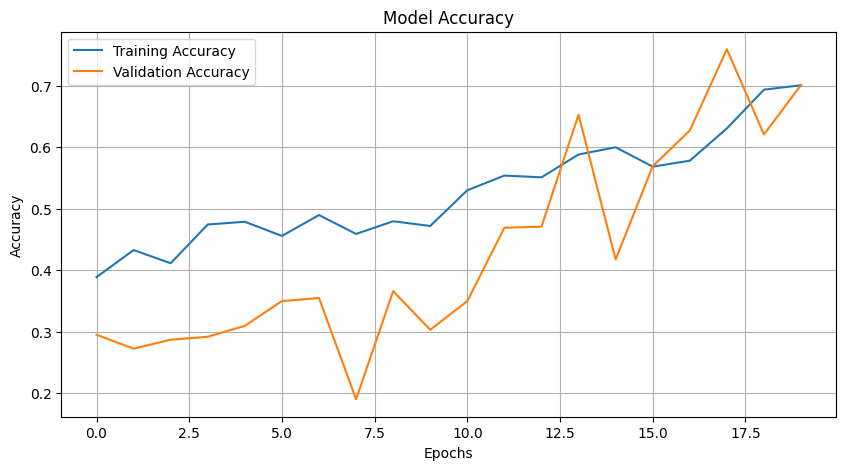

In [19]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

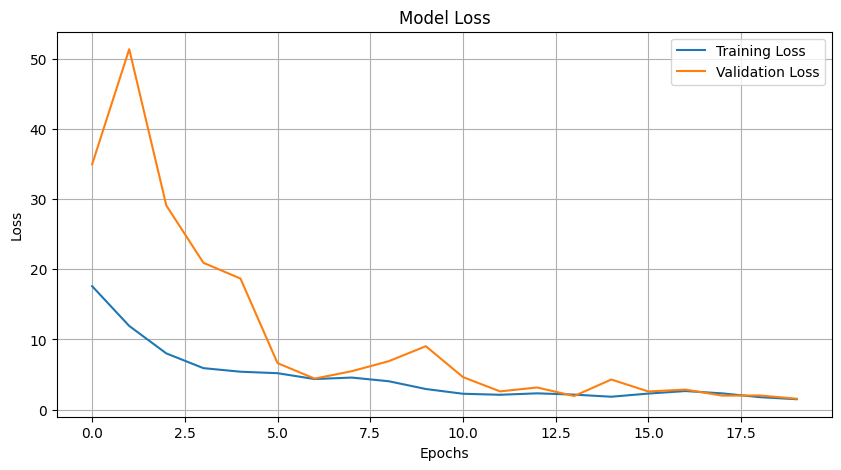

In [20]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


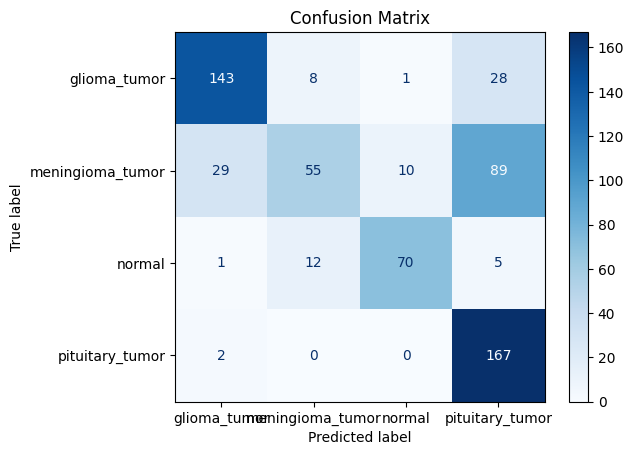

In [21]:
y_pred = model2.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
y_pred = model2.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred_classes)
print(f"Overall Accuracy: {accuracy}\n")

report = classification_report(np.argmax(y_val, axis=1), y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
Overall Accuracy: 0.7016129032258065

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.79      0.81       180
meningioma_tumor       0.73      0.30      0.43       183
          normal       0.86      0.80      0.83        88
 pituitary_tumor       0.58      0.99      0.73       169

        accuracy                           0.70       620
       macro avg       0.75      0.72      0.70       620
    weighted avg       0.73      0.70      0.68       620

